In [94]:
import numpy as np
import struct
from array import array
import pandas as pd
import os
from os.path  import join
import random as rn
from sklearn.neural_network import MLPClassifier
import graphviz
import pydotplus
from IPython.display import Image
from io import StringIO
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import random
import matplotlib.pyplot as plt
import time
import mlrose_hiive as mlrose
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score

In [3]:
"""
Loading in the dataset into a pandas dataframe object.

For the following segments the code snippets were retreved from: https://www.kaggle.com/code/anetakovacheva/interpreting-a-music-genre-classifier
"""

%matplotlib inline

input_path = 'musicgenre_datafolder'
file_path = join(input_path, 'music_genre.csv')

music_data = pd.read_csv(file_path)

In [4]:
"""
Cleaning and Pre-Processing all of the data
"""

"""
There are some duplicated data that needs to be cleaned up
"""
music_data.duplicated().any()
duplicated = music_data.duplicated()
music_data[duplicated]
music_data.iloc[9999:10006]
music_data.drop([10000, 10001, 10002, 10003, 10004], inplace = True)

"""
Removing some columns that don't matter or will complicated the training too much
"""
music_data.reset_index(inplace = True)
music_data = music_data.drop(["artist_name", "index", "instance_id", "track_name", "obtained_date"], axis = 1)

"""
Normalizing the music data such that it removes invalid values for 'tempo' and converts
the column values into a float
"""
music_data = music_data.drop(music_data[music_data["tempo"] == "?"].index)
music_data["tempo"] = music_data["tempo"].astype("float")
music_data["tempo"] = np.around(music_data["tempo"], decimals = 2)

"""
Encoding the columns that are strings with LabelEncoder since this will mess
up the algorithms that require numeric values
"""
key_encoder = LabelEncoder()
mode_encoder = LabelEncoder()
music_data["key"] = key_encoder.fit_transform(music_data["key"])
music_data["mode"] = mode_encoder.fit_transform(music_data["mode"])

"""
Separating out the column features from the music genre label
"""
music_features = music_data.drop("music_genre", axis = 1)
music_labels = music_data["music_genre"]

"""
Scaling the features out into a scale centered around 0 with a standard deviation of 1
"""
scaler = StandardScaler()
music_features_scaled = scaler.fit_transform(music_features)

In [5]:
"""
Splitting the data into Training and Testing Data Sets
"""
train_features, test_features, train_labels, test_labels = train_test_split(
    music_features_scaled, music_labels, test_size = 0.1, stratify = music_labels)


In [6]:
train_labels = pd.Series.to_numpy(train_labels, copy=True)
test_labels = pd.Series.to_numpy(test_labels, copy=True)

In [7]:
one_hot = OneHotEncoder()

y_train_hot = one_hot.fit_transform(train_labels.reshape(-1, 1)).toarray()
y_test_hot = one_hot.transform(test_labels.reshape(-1, 1)).toarray()

In [8]:
"""
Setting up seed values for reproducability
"""
starting_seed = 1234
seed_values = []

for i in range(0, 5):
    seed_values.append(starting_seed + i)

# np.random.seed(seed)
# rn.seed(seed)
# os.environ['PYTHONHASHSEED'] = str(seed)

In [157]:
"""
Actually training the NN with the mlrose package using the hyperparameters that were found to be 
desired in A1.

This is to recreate the learning / loss curves that were generated in A1 using mlrose.
"""

# Hyperparameters for NN
hidden_nodes = [100, 50, 10]
activation = 'relu'
algorithm = 'random_hill_climb'
max_iters = 50
bias = True
is_classifier = True
learning_rate = 0.2
early_stopping = False
max_attempts = 10
clip_max = 5

nn_model = mlrose.NeuralNetwork(
    hidden_nodes = hidden_nodes,
    activation = activation,
    algorithm = algorithm,
    max_iters = max_iters,
    bias = bias,
    is_classifier = is_classifier,
    learning_rate = learning_rate,
    early_stopping = early_stopping,
    max_attempts = max_attempts,
#     clip_max = clip_max,
    random_state = seed_values[4],
    curve = True
)

nn_model.fit(train_features, y_train_hot)

NeuralNetwork(curve=True, hidden_nodes=[100, 50, 10], learning_rate=0.2,
              max_iters=50, random_state=1238)

In [158]:
print(nn_model.fitted_weights)
print(nn_model.fitness_curve)
print(nn_model.loss)
print(nn_model.predicted_probs)

[ 0.85511765 -0.21738124 -0.17115633 ...  0.59541652 -0.95995017
 -0.01869913]
[[26.95908818  2.        ]
 [26.95908818  3.        ]
 [26.95212381  5.        ]
 [26.95212381  6.        ]
 [26.95166506  8.        ]
 [26.94751858 10.        ]
 [26.94660823 12.        ]
 [26.93899775 14.        ]
 [26.93692076 16.        ]
 [26.93692076 17.        ]
 [26.92977313 19.        ]
 [26.92977313 20.        ]
 [26.92977313 21.        ]
 [26.92977313 22.        ]
 [26.92510125 24.        ]
 [26.92510125 25.        ]
 [26.92237365 27.        ]
 [26.90418063 29.        ]
 [26.90418063 30.        ]
 [26.90418063 31.        ]
 [26.90418063 32.        ]
 [26.89627471 34.        ]
 [26.89627471 35.        ]
 [26.72689221 37.        ]
 [26.72313138 39.        ]
 [26.72282999 41.        ]
 [26.72282999 42.        ]
 [26.72282999 43.        ]
 [26.70598782 45.        ]
 [26.70084147 47.        ]
 [26.70084147 48.        ]
 [26.70084147 49.        ]
 [26.70025528 51.        ]
 [26.61542248 53.        ]
 [2

In [159]:
from sklearn.metrics import accuracy_score

# Predict labels for train set and assess accuracy
y_train_pred = nn_model.predict(train_features)

y_train_accuracy = accuracy_score(y_train_hot, y_train_pred)
print(y_train_accuracy)

0.11199960511377659


In [160]:
print(y_train_pred[:25])

[[0 1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]]


In [9]:
"""
Got this code from https://www.kaggle.com/code/hojjatk/read-mnist-dataset/notebook for 
instructions on how to load data from the MNIST dataset
"""
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
#             img = img.reshape(28, 28)
            images[i][:] = img            
        
        return np.array(images), np.array(labels)
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)  

In [54]:
#
# Verify Reading Dataset via MnistDataloader class
#
%matplotlib inline
import random
import matplotlib.pyplot as plt

#
# Set file paths based on added MNIST Datasets
#
input_path = 'mnist_datafolder'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

In [55]:
"""
Setting up seed values for reproducability
"""
starting_seed = 1234
seed_values = []

for i in range(0, 5):
    seed_values.append(starting_seed + i)

# np.random.seed(seed)
# rn.seed(seed)
# os.environ['PYTHONHASHSEED'] = str(seed)

In [56]:
"""
Need to do some data pre-processing to make it work with the mlrose NN class
"""

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(x_train)
X_test_scaled = scaler.transform(x_test)

one_hot = OneHotEncoder()

y_train_hot = one_hot.fit_transform(y_train.reshape(-1, 1)).toarray()
y_test_hot = one_hot.transform(y_test.reshape(-1, 1)).toarray()

In [21]:
"""
Actually training the MLP Classifier to generate the graph for the learning graph visualizer.
This should utilize the percentage of samples lists that use randomly selected samples of the
overall training data. This is so that we can test the accuracy (using cross-validation) across different
training data size samples to see at what point the accuracy score stops being affected by the size of the training
samples. This is also to see at what point the data might start getting overfit.

This is to generate the Accuracy Learning Curve.
"""
# Defining hyperparameters here
hidden_layer_sizes = [100, 50, 10]
activation = 'relu'
learning_rate = 'constant'
max_iter = 1 # Setting this to 1 since we want to control the epochs ourselves
warm_start = True # This is to stack the training across different epochs

number_of_epochs = 15

# lists to hold the results of training / validation scores
x_axis_list = []
avg_train_scores_list = []
avg_validation_scores_list = []
avg_train_loss_values = []
avg_validation_loss_values = []
iteration_wall_clock_list = []

# First declaring the Decision Tree Classifer from scikit-learn
clf = MLPClassifier(
    hidden_layer_sizes=hidden_layer_sizes,
    activation=activation,
    learning_rate=learning_rate,
    max_iter=max_iter,
    warm_start=warm_start,
    random_state=seed_values[0]
)

for epoch_iteration in range(1, number_of_epochs + 1):
    
    # cross_val_score doesn't increase across epoch runs for some reason so I need to split it myself
    train_data, val_data, train_label, val_label = train_test_split(X_train_scaled, y_train_hot, test_size=0.2, random_state=seed_values[0])
    start_time = time.time()
    clf.fit(train_data, train_label)
    training_time = time.time() - start_time
    
    accuracy_score = clf.score(train_data, train_label)
    validation_score = clf.score(val_data, val_label)
#     loss_score = clf.loss_
    train_loss_score = log_loss(train_label, clf.predict_proba(train_data))
    val_loss_score = log_loss(val_label, clf.predict_proba(val_data))
    
    x_axis_list.append(epoch_iteration)
    avg_train_scores_list.append(accuracy_score)
    avg_validation_scores_list.append(validation_score)
    avg_train_loss_values.append(train_loss_score)
    avg_validation_loss_values.append(val_loss_score)
    iteration_wall_clock_list.append(training_time)
    
    print("=============================================")
    print("Run for " + str(epoch_iteration) + " epoch")
    print("Training Score: " + str(accuracy_score))
    print("Validation Score: " + str(validation_score))
#     print("Loss Score: " + str(loss_score))
    print("Training Loss Score: " + str(train_loss_score))
    print("Validation Loss Score: " + str(val_loss_score))
    print("Training Time: " + str(training_time))
    print("=============================================")

    

Run for 1 epoch
Training Score: 0.7763333333333333
Validation Score: 0.7696666666666667
Training Loss Score: 0.49907822087063164
Validation Loss Score: 0.5158592211776745
Training Time: 1.1012060642242432
Run for 2 epoch
Training Score: 0.8741458333333333
Validation Score: 0.86675
Training Loss Score: 0.3048326971270231
Validation Loss Score: 0.3281046165157908
Training Time: 1.120150089263916
Run for 3 epoch
Training Score: 0.9156875
Validation Score: 0.9058333333333334
Training Loss Score: 0.2202337056805823
Validation Loss Score: 0.2478132159625827
Training Time: 1.0113370418548584
Run for 4 epoch
Training Score: 0.935125
Validation Score: 0.92275
Training Loss Score: 0.17259490084947
Validation Loss Score: 0.20291396968805275
Training Time: 1.0988080501556396
Run for 5 epoch
Training Score: 0.9459583333333333
Validation Score: 0.9303333333333333
Training Loss Score: 0.14473787718374537
Validation Loss Score: 0.17982931871436397
Training Time: 1.0023951530456543
Run for 6 epoch
Trai

In [57]:
"""
Actually training the NN with the mlrose package using the hyperparameters that were found to be 
desired in A1.

This is to recreate the learning / loss curves that were generated in A1 using mlrose.
"""

# Hyperparameters for NN
hidden_nodes = [100, 50, 10]
activation = 'relu'
algorithm = 'gradient_descent'
max_iters = 100
bias = True
is_classifier = True
learning_rate = 0.00001
early_stopping = True
max_attempts = 20
clip_max = 1

iteration_sizes = [1 * i for i in range(0, 1000, 50)]
iteration_sizes.pop(0)

rhc_fit_scores = []

# Want to loop across the different problem sizes
# for iteration_size in iteration_sizes:
rhc_data_avg = []

nn_modelA1 = mlrose.NeuralNetwork(
    hidden_nodes = hidden_nodes,
    activation = activation,
    algorithm = algorithm,
    max_iters = max_iters,
    bias = bias,
    is_classifier = is_classifier,
    learning_rate = learning_rate,
    early_stopping = early_stopping,
    max_attempts = max_attempts,
    clip_max = clip_max,
    random_state = seed_values[4],
    curve = True
)

nn_modelA1.fit(X_train_scaled, y_train_hot)

NeuralNetwork(algorithm='gradient_descent', clip_max=1, curve=True,
              early_stopping=True, hidden_nodes=[100, 50, 10],
              learning_rate=1e-05, max_attempts=20, random_state=1238)

In [58]:
print(nn_modelA1.fitted_weights)
print(nn_modelA1.fitness_curve)
print(nn_modelA1.loss)
print(nn_modelA1.predicted_probs)

[ 0.85511765 -0.21738124 -0.17115633 ...  1.          1.
  1.        ]
[-29.89834612 -31.1090759   -2.35962391  -2.30804776  -2.3028777
  -2.30286553  -2.30285445  -2.30284451  -2.3028357   -2.30282801
  -2.30282137  -2.3028157   -2.30281089  -2.30280684  -2.30280345
  -2.30280052  -2.3027971   -2.30279416  -2.30279107  -2.30278749
  -2.30278425  -2.30278084  -2.30277703  -2.30277348  -2.30277029
  -2.30276788  -2.30276558  -2.3027634   -2.30276133  -2.30275937
  -2.30275752  -2.30275577  -2.30275413  -2.30275257  -2.30275111
  -2.30274972  -2.30274812  -2.30274661  -2.30274519  -2.30274384
  -2.30274256  -2.30274135  -2.3027402   -2.3027391   -2.30273804
  -2.30273704  -2.30273607  -2.30273514  -2.30273424  -2.30273338
  -2.30273254  -2.30273172  -2.30273051  -2.30272935  -2.30272822
  -2.30272712  -2.30272605  -2.30272501  -2.30272392  -2.30272236
  -2.30272082  -2.30271928  -2.30271776  -2.30271624  -2.30271473
  -2.30271323  -2.30271174  -2.30271025  -2.30270877  -2.3027073
  -2.30

In [59]:
from sklearn.metrics import accuracy_score

# Predict labels for train set and assess accuracy
y_train_pred = nn_modelA1.predict(X_train_scaled)

y_train_accuracy = accuracy_score(y_train_hot, y_train_pred)
print(y_train_accuracy)

0.09873333333333334


In [60]:
print(y_train[3])
print(y_train_pred[3])
print(y_train_hot[3])

1
[1 0 0 0 0 0 0 0 0 0]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [114]:
"""
Bringing in the IRIS dataset
"""
# Trying the Machine Learning Optimization
from sklearn.datasets import load_iris

data = load_iris()

print(data.data[0])

print(data.feature_names)

print(data.target[0])

print(data.target_names[data.target[0]])

print(np.min(data.data, axis = 0))

print(np.max(data.data, axis = 0))

print(np.unique(data.target))

[5.1 3.5 1.4 0.2]
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
0
setosa
[4.3 2.  1.  0.1]
[7.9 4.4 6.9 2.5]
[0 1 2]


In [115]:
"""
Preprocessing the IRIS dataset
"""

X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, \
                                                    test_size = 0.2, random_state = 3)

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

one_hot = OneHotEncoder()

y_train_hot = one_hot.fit_transform(y_train.reshape(-1, 1)).todense()
y_test_hot = one_hot.transform(y_test.reshape(-1, 1)).todense()

In [130]:
"""
Trying out the performance on the typical backprop Neural Network
"""

# Hyperparameters for NN
hidden_nodes = [28]
activation = 'relu'
algorithm = 'gradient_descent'
bias = True
is_classifier = True
learning_rate = 0.001
early_stopping = True
max_attempts = 10
clip_max = 5

iteration_sizes = [1 * i for i in range(0, 1550, 50)]
iteration_sizes.pop(0)

train_fitness_scores = []
train_loss_scores = []
val_fitness_scores = []
val_loss_scores = []
wall_clock_time = []

for iteration_size in iteration_sizes:
    avg_train_fitness_scores = []
    avg_train_loss_scores = []
    avg_val_fitness_scores = []
    avg_val_loss_scores = []
    avg_wall_clock_time = []
    
    print(f"Running iteration size {iteration_size}")
    for seed in seed_values:
        
        nn_model_backprop = mlrose.NeuralNetwork(
            hidden_nodes = hidden_nodes,
            activation = activation,
            algorithm = algorithm,
            max_iters = iteration_size,
            bias = bias,
            is_classifier = is_classifier,
            learning_rate = learning_rate,
            early_stopping = early_stopping,
            max_attempts = max_attempts,
            clip_max = clip_max,
            random_state = seed,
            curve = True
        )
        
        train_data, val_data, train_label, val_label = train_test_split(X_train_scaled, y_train_hot, test_size=0.3, random_state=seed)
        
        start_time = time.time()
        nn_model_backprop.fit(train_data, train_label)
        training_time = time.time() - start_time
        
        y_train_pred = nn_model_backprop.predict(train_data)
        y_train_accuracy = accuracy_score(train_label, y_train_pred)
        
        y_val_pred = nn_model_backprop.predict(val_data)
        y_val_accuracy = accuracy_score(val_label, y_val_pred)
        
        train_loss_score = nn_model_backprop.loss
        
        nn_model_backprop = mlrose.NeuralNetwork(
            hidden_nodes = hidden_nodes,
            activation = activation,
            algorithm = algorithm,
            max_iters = iteration_size,
            bias = bias,
            is_classifier = is_classifier,
            learning_rate = learning_rate,
            early_stopping = early_stopping,
            max_attempts = max_attempts,
            clip_max = clip_max,
            random_state = seed,
            curve = True
        )
        nn_model_backprop.fit(val_data, val_label)
        
        val_loss_score = nn_model_backprop.loss

        avg_train_fitness_scores.append(y_train_accuracy)
        avg_train_loss_scores.append(train_loss_score)
        
        avg_val_fitness_scores.append(y_val_accuracy)
        avg_val_loss_scores.append(val_loss_score)
        
        avg_wall_clock_time.append(training_time)
    
    avg_train_fitness_score = np.average(avg_val_fitness_scores)
    print(f"Avg training fitness {avg_train_fitness_score}")
    train_fitness_scores.append(avg_train_fitness_score)
    
    avg_train_loss_score = np.average(avg_train_loss_scores)
    print(f"Avg training loss {avg_train_loss_score}")
    train_loss_scores.append(avg_train_loss_score)
    
    avg_val_fitness_score = np.average(avg_val_fitness_scores)
    print(f"Avg val fitness {avg_val_fitness_score}")
    val_fitness_scores.append(avg_val_fitness_score)
    
    avg_val_loss_score = np.average(avg_val_loss_scores)
    print(f"Avg val loss {avg_val_loss_score}")
    val_loss_scores.append(avg_val_loss_score)
    
    avg_wall_clock = np.average(avg_wall_clock_time)
    print(f"Avg time {avg_wall_clock}")
    wall_clock_time.append(avg_wall_clock)
    
    print("========================================")

Running iteration size 50
Avg training fitness 0.85
Avg training loss 0.41820945149706706
Avg val fitness 0.85
Avg val loss 0.5296397823210438
Avg time 0.054542160034179686
Running iteration size 100
Avg training fitness 0.888888888888889
Avg training loss 0.3244321452577309
Avg val fitness 0.888888888888889
Avg val loss 0.42528152216106585
Avg time 0.09884347915649414
Running iteration size 150
Avg training fitness 0.9388888888888888
Avg training loss 0.26871731788942965
Avg val fitness 0.9388888888888888
Avg val loss 0.3713366852086807
Avg time 0.14808406829833984
Running iteration size 200
Avg training fitness 0.961111111111111
Avg training loss 0.22882216476330078
Avg val fitness 0.961111111111111
Avg val loss 0.3349021365077044
Avg time 0.19714322090148925
Running iteration size 250
Avg training fitness 0.961111111111111
Avg training loss 0.19865969914162845
Avg val fitness 0.961111111111111
Avg val loss 0.3074169718331642
Avg time 0.24886741638183593
Running iteration size 300
Av

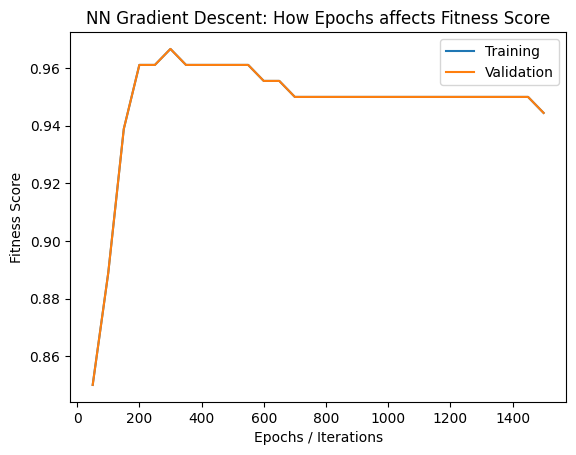

In [106]:
"""
Plotting the fitness score (Y axis) to number of epochs / iterations (X axis) for KnapSack
"""

plt.plot(iteration_sizes, train_fitness_scores, label = 'Training')
plt.plot(iteration_sizes, val_fitness_scores, label = 'Validation')

plt.xlabel("Epochs / Iterations")
plt.ylabel("Fitness Score")
plt.title("NN Gradient Descent: How Epochs affects Fitness Score")
plt.legend()
plt.show()

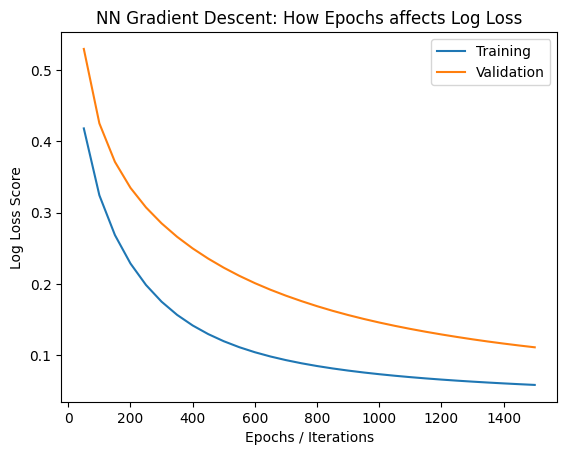

In [107]:
"""
Plotting the fitness score (Y axis) to number of epochs / iterations (X axis) for KnapSack
"""

plt.plot(iteration_sizes, train_loss_scores, label = 'Training')
plt.plot(iteration_sizes, val_loss_scores, label = 'Validation')

plt.xlabel("Epochs / Iterations")
plt.ylabel("Log Loss Score")
plt.title("NN Gradient Descent: How Epochs affects Log Loss")
plt.legend()
plt.show()

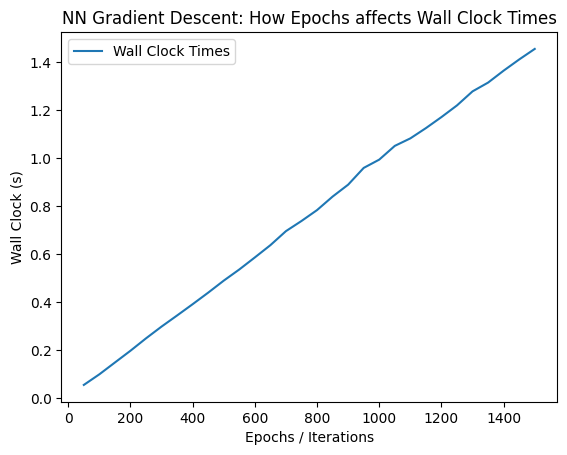

In [131]:
"""
Plotting the fitness score (Y axis) to number of epochs / iterations (X axis) for KnapSack
"""

plt.plot(iteration_sizes, wall_clock_time, label = 'Wall Clock Times')

plt.xlabel("Epochs / Iterations")
plt.ylabel("Wall Clock (s)")
plt.title("NN Gradient Descent: How Epochs affects Wall Clock Times")
plt.legend()
plt.show()

In [122]:
"""
Trying out the performance on the typical backprop Neural Network
"""

# Hyperparameters for NN
hidden_nodes = [28]
activation = 'relu'
algorithm = 'random_hill_climb'
bias = True
is_classifier = True
learning_rate = 0.4
early_stopping = True
max_attempts = 10
clip_max = 5

# hyperparameters for RHC
restarts = 10

iteration_sizes = [1 * i for i in range(0, 1550, 50)]
iteration_sizes.pop(0)

train_fitness_scores = []
train_loss_scores = []
val_fitness_scores = []
val_loss_scores = []
wall_clock_time = []

for iteration_size in iteration_sizes:
    avg_train_fitness_scores = []
    avg_train_loss_scores = []
    avg_val_fitness_scores = []
    avg_val_loss_scores = []
    avg_wall_clock_time = []
    
    print(f"Running iteration size {iteration_size}")
    for seed in seed_values:
        
        nn_model_backprop = mlrose.NeuralNetwork(
            hidden_nodes = hidden_nodes,
            activation = activation,
            algorithm = algorithm,
            max_iters = iteration_size,
            bias = bias,
            is_classifier = is_classifier,
            learning_rate = learning_rate,
            early_stopping = early_stopping,
            max_attempts = max_attempts,
            clip_max = clip_max,
            random_state = seed,
            restarts = restarts,
            curve = True
        )
        
        train_data, val_data, train_label, val_label = train_test_split(X_train_scaled, y_train_hot, test_size=0.3, random_state=seed)
        
        start_time = time.time()
        nn_model_backprop.fit(train_data, train_label)
        training_time = time.time() - start_time
        
        y_train_pred = nn_model_backprop.predict(train_data)
        y_train_accuracy = accuracy_score(train_label, y_train_pred)
        
        y_val_pred = nn_model_backprop.predict(val_data)
        y_val_accuracy = accuracy_score(val_label, y_val_pred)
        
        train_loss_score = nn_model_backprop.loss
        
        nn_model_backprop = mlrose.NeuralNetwork(
            hidden_nodes = hidden_nodes,
            activation = activation,
            algorithm = algorithm,
            max_iters = iteration_size,
            bias = bias,
            is_classifier = is_classifier,
            learning_rate = learning_rate,
            early_stopping = early_stopping,
            max_attempts = max_attempts,
            clip_max = clip_max,
            random_state = seed,
            restarts = restarts,
            curve = True
        )
        nn_model_backprop.fit(val_data, val_label)
        
        val_loss_score = nn_model_backprop.loss

        avg_train_fitness_scores.append(y_train_accuracy)
        avg_train_loss_scores.append(train_loss_score)
        
        avg_val_fitness_scores.append(y_val_accuracy)
        avg_val_loss_scores.append(val_loss_score)
        
        avg_wall_clock_time.append(training_time)
    
    avg_train_fitness_score = np.average(avg_val_fitness_scores)
    print(f"Avg training fitness {avg_train_fitness_score}")
    train_fitness_scores.append(avg_train_fitness_score)
    
    avg_train_loss_score = np.average(avg_train_loss_scores)
    print(f"Avg training loss {avg_train_loss_score}")
    train_loss_scores.append(avg_train_loss_score)
    
    avg_val_fitness_score = np.average(avg_val_fitness_scores)
    print(f"Avg val fitness {avg_val_fitness_score}")
    val_fitness_scores.append(avg_val_fitness_score)
    
    avg_val_loss_score = np.average(avg_val_loss_scores)
    print(f"Avg val loss {avg_val_loss_score}")
    val_loss_scores.append(avg_val_loss_score)
    
    avg_wall_clock = np.average(avg_wall_clock_time)
    print(f"Avg time {avg_wall_clock}")
    wall_clock_time.append(avg_wall_clock)
    
    print("========================================")

Running iteration size 50
Avg training fitness 0.6833333333333333
Avg training loss 0.8683140441133498
Avg val fitness 0.6833333333333333
Avg val loss 0.7651773197212131
Avg time 0.3043332576751709
Running iteration size 100
Avg training fitness 0.6888888888888889
Avg training loss 0.6812605260476718
Avg val fitness 0.6888888888888889
Avg val loss 0.6029051068761554
Avg time 0.5292468070983887
Running iteration size 150
Avg training fitness 0.75
Avg training loss 0.517473121181548
Avg val fitness 0.75
Avg val loss 0.49938187205532303
Avg time 0.6373023986816406
Running iteration size 200
Avg training fitness 0.8055555555555556
Avg training loss 0.4501290442981647
Avg val fitness 0.8055555555555556
Avg val loss 0.46418871426112346
Avg time 0.7372570037841797
Running iteration size 250
Avg training fitness 0.8333333333333334
Avg training loss 0.4015816655791996
Avg val fitness 0.8333333333333334
Avg val loss 0.449939100820855
Avg time 0.8420558929443359
Running iteration size 300
Avg tra

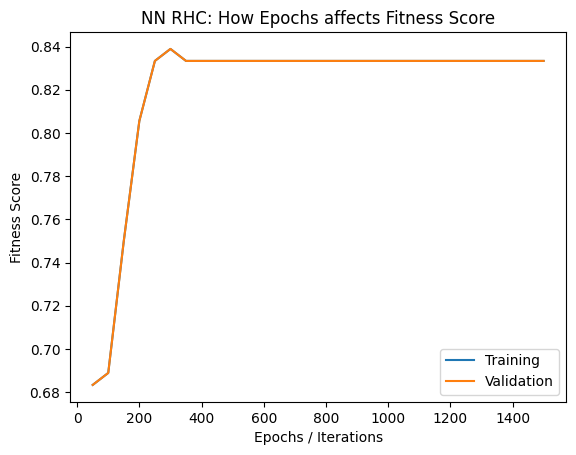

In [120]:
"""
Plotting the fitness score (Y axis) to number of epochs / iterations (X axis) for KnapSack
"""

plt.plot(iteration_sizes, train_fitness_scores, label = 'Training')
plt.plot(iteration_sizes, val_fitness_scores, label = 'Validation')

plt.xlabel("Epochs / Iterations")
plt.ylabel("Fitness Score")
plt.title("NN RHC: How Epochs affects Fitness Score")
plt.legend()
plt.show()

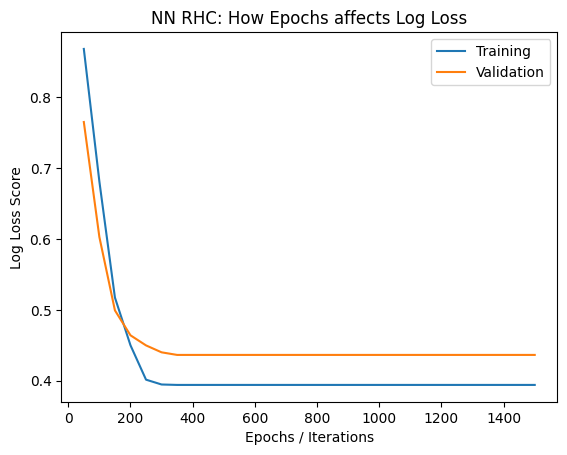

In [121]:
"""
Plotting the fitness score (Y axis) to number of epochs / iterations (X axis) for KnapSack
"""

plt.plot(iteration_sizes, train_loss_scores, label = 'Training')
plt.plot(iteration_sizes, val_loss_scores, label = 'Validation')

plt.xlabel("Epochs / Iterations")
plt.ylabel("Log Loss Score")
plt.title("NN RHC: How Epochs affects Log Loss")
plt.legend()
plt.show()

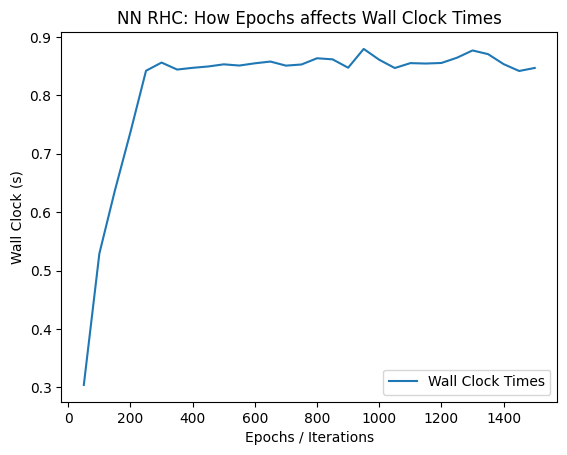

In [123]:
"""
Plotting the fitness score (Y axis) to number of epochs / iterations (X axis) for KnapSack
"""

plt.plot(iteration_sizes, wall_clock_time, label = 'Wall Clock Times')

plt.xlabel("Epochs / Iterations")
plt.ylabel("Wall Clock (s)")
plt.title("NN RHC: How Epochs affects Wall Clock Times")
plt.legend()
plt.show()

In [124]:
"""
Trying out the performance on the typical backprop Neural Network
"""

# Hyperparameters for NN
hidden_nodes = [28]
activation = 'relu'
algorithm = 'simulated_annealing'
bias = True
is_classifier = True
learning_rate = 0.4
early_stopping = True
max_attempts = 10
clip_max = 5

# hyperparameters for SA
schedule = mlrose.ExpDecay()

iteration_sizes = [1 * i for i in range(0, 1550, 50)]
iteration_sizes.pop(0)

train_fitness_scores = []
train_loss_scores = []
val_fitness_scores = []
val_loss_scores = []
wall_clock_time = []

for iteration_size in iteration_sizes:
    avg_train_fitness_scores = []
    avg_train_loss_scores = []
    avg_val_fitness_scores = []
    avg_val_loss_scores = []
    avg_wall_clock_time = []
    
    print(f"Running iteration size {iteration_size}")
    for seed in seed_values:
        
        nn_model_backprop = mlrose.NeuralNetwork(
            hidden_nodes = hidden_nodes,
            activation = activation,
            algorithm = algorithm,
            max_iters = iteration_size,
            bias = bias,
            is_classifier = is_classifier,
            learning_rate = learning_rate,
            early_stopping = early_stopping,
            max_attempts = max_attempts,
            clip_max = clip_max,
            random_state = seed,
            schedule = schedule,
            curve = True
        )
        
        train_data, val_data, train_label, val_label = train_test_split(X_train_scaled, y_train_hot, test_size=0.3, random_state=seed)
        
        start_time = time.time()
        nn_model_backprop.fit(train_data, train_label)
        training_time = time.time() - start_time
        
        y_train_pred = nn_model_backprop.predict(train_data)
        y_train_accuracy = accuracy_score(train_label, y_train_pred)
        
        y_val_pred = nn_model_backprop.predict(val_data)
        y_val_accuracy = accuracy_score(val_label, y_val_pred)
        
        train_loss_score = nn_model_backprop.loss
        
        nn_model_backprop = mlrose.NeuralNetwork(
            hidden_nodes = hidden_nodes,
            activation = activation,
            algorithm = algorithm,
            max_iters = iteration_size,
            bias = bias,
            is_classifier = is_classifier,
            learning_rate = learning_rate,
            early_stopping = early_stopping,
            max_attempts = max_attempts,
            clip_max = clip_max,
            random_state = seed,
            schedule = schedule,
            curve = True
        )
        nn_model_backprop.fit(val_data, val_label)
        
        val_loss_score = nn_model_backprop.loss

        avg_train_fitness_scores.append(y_train_accuracy)
        avg_train_loss_scores.append(train_loss_score)
        
        avg_val_fitness_scores.append(y_val_accuracy)
        avg_val_loss_scores.append(val_loss_score)
        
        avg_wall_clock_time.append(training_time)
    
    avg_train_fitness_score = np.average(avg_val_fitness_scores)
    print(f"Avg training fitness {avg_train_fitness_score}")
    train_fitness_scores.append(avg_train_fitness_score)
    
    avg_train_loss_score = np.average(avg_train_loss_scores)
    print(f"Avg training loss {avg_train_loss_score}")
    train_loss_scores.append(avg_train_loss_score)
    
    avg_val_fitness_score = np.average(avg_val_fitness_scores)
    print(f"Avg val fitness {avg_val_fitness_score}")
    val_fitness_scores.append(avg_val_fitness_score)
    
    avg_val_loss_score = np.average(avg_val_loss_scores)
    print(f"Avg val loss {avg_val_loss_score}")
    val_loss_scores.append(avg_val_loss_score)
    
    avg_wall_clock = np.average(avg_wall_clock_time)
    print(f"Avg time {avg_wall_clock}")
    wall_clock_time.append(avg_wall_clock)
    
    print("========================================")

Running iteration size 50
Avg training fitness 0.4055555555555556
Avg training loss 1.7712161524817607
Avg val fitness 0.4055555555555556
Avg val loss 1.4165159412516526
Avg time 0.04894609451293945
Running iteration size 100
Avg training fitness 0.3333333333333333
Avg training loss 1.913036084773088
Avg val fitness 0.3333333333333333
Avg val loss 1.6838829775399127
Avg time 0.09146862030029297
Running iteration size 150
Avg training fitness 0.38888888888888884
Avg training loss 1.8657434460569866
Avg val fitness 0.38888888888888884
Avg val loss 1.445771661494812
Avg time 0.1355666160583496
Running iteration size 200
Avg training fitness 0.43888888888888894
Avg training loss 1.6177321994187643
Avg val fitness 0.43888888888888894
Avg val loss 1.3588952986741294
Avg time 0.1806243896484375
Running iteration size 250
Avg training fitness 0.4611111111111111
Avg training loss 1.6424343671316712
Avg val fitness 0.4611111111111111
Avg val loss 1.3178402465604435
Avg time 0.22413945198059082
R

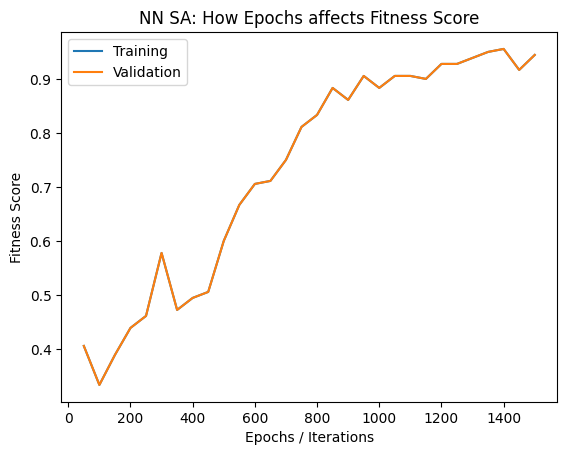

In [117]:
"""
Plotting the fitness score (Y axis) to number of epochs / iterations (X axis) for KnapSack
"""

plt.plot(iteration_sizes, train_fitness_scores, label = 'Training')
plt.plot(iteration_sizes, val_fitness_scores, label = 'Validation')

plt.xlabel("Epochs / Iterations")
plt.ylabel("Fitness Score")
plt.title("NN SA: How Epochs affects Fitness Score")
plt.legend()
plt.show()

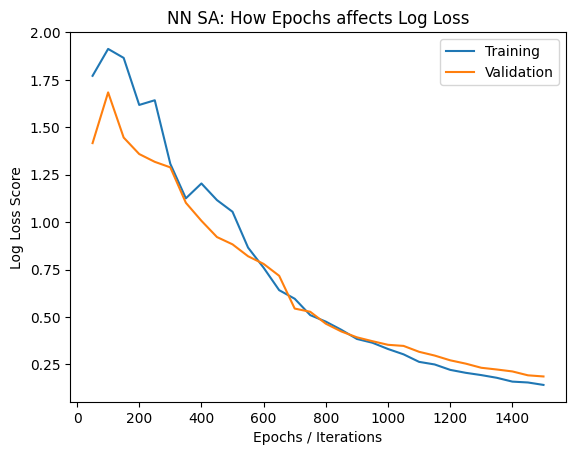

In [118]:
"""
Plotting the fitness score (Y axis) to number of epochs / iterations (X axis) for KnapSack
"""

plt.plot(iteration_sizes, train_loss_scores, label = 'Training')
plt.plot(iteration_sizes, val_loss_scores, label = 'Validation')

plt.xlabel("Epochs / Iterations")
plt.ylabel("Log Loss Score")
plt.title("NN SA: How Epochs affects Log Loss")
plt.legend()
plt.show()

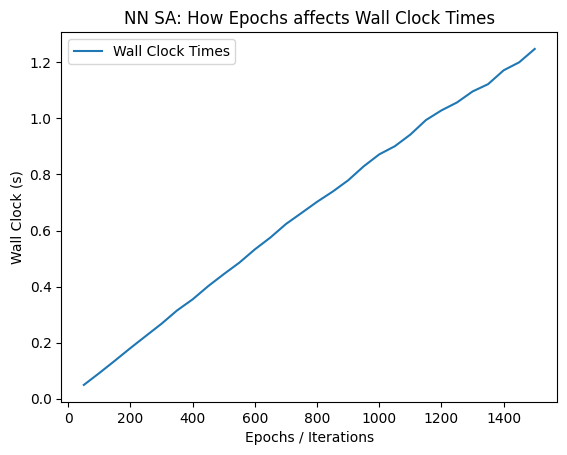

In [125]:
"""
Plotting the fitness score (Y axis) to number of epochs / iterations (X axis) for KnapSack
"""

plt.plot(iteration_sizes, wall_clock_time, label = 'Wall Clock Times')

plt.xlabel("Epochs / Iterations")
plt.ylabel("Wall Clock (s)")
plt.title("NN SA: How Epochs affects Wall Clock Times")
plt.legend()
plt.show()

In [132]:
"""
Trying out the performance on the typical backprop Neural Network
"""

# Hyperparameters for NN
hidden_nodes = [28]
activation = 'relu'
algorithm = 'simulated_annealing'
bias = True
is_classifier = True
learning_rate = 0.4
early_stopping = True
max_attempts = 10
clip_max = 5

# hyperparameters for GA
pop_size = 200
mutation_prob = 0.3

iteration_sizes = [1 * i for i in range(0, 1550, 50)]
iteration_sizes.pop(0)

train_fitness_scores = []
train_loss_scores = []
val_fitness_scores = []
val_loss_scores = []
wall_clock_time = []

for iteration_size in iteration_sizes:
    avg_train_fitness_scores = []
    avg_train_loss_scores = []
    avg_val_fitness_scores = []
    avg_val_loss_scores = []
    avg_wall_clock_time = []
    
    print(f"Running iteration size {iteration_size}")
    for seed in seed_values:
        
        nn_model_backprop = mlrose.NeuralNetwork(
            hidden_nodes = hidden_nodes,
            activation = activation,
            algorithm = algorithm,
            max_iters = iteration_size,
            bias = bias,
            is_classifier = is_classifier,
            learning_rate = learning_rate,
            early_stopping = early_stopping,
            max_attempts = max_attempts,
            clip_max = clip_max,
            random_state = seed,
            pop_size = pop_size,
            mutation_prob = mutation_prob,
            curve = True
        )
        
        train_data, val_data, train_label, val_label = train_test_split(X_train_scaled, y_train_hot, test_size=0.3, random_state=seed)
        
        start_time = time.time()
        nn_model_backprop.fit(train_data, train_label)
        training_time = time.time() - start_time
        
        y_train_pred = nn_model_backprop.predict(train_data)
        y_train_accuracy = accuracy_score(train_label, y_train_pred)
        
        y_val_pred = nn_model_backprop.predict(val_data)
        y_val_accuracy = accuracy_score(val_label, y_val_pred)
        
        train_loss_score = nn_model_backprop.loss
        
        nn_model_backprop = mlrose.NeuralNetwork(
            hidden_nodes = hidden_nodes,
            activation = activation,
            algorithm = algorithm,
            max_iters = iteration_size,
            bias = bias,
            is_classifier = is_classifier,
            learning_rate = learning_rate,
            early_stopping = early_stopping,
            max_attempts = max_attempts,
            clip_max = clip_max,
            random_state = seed,
            pop_size = pop_size,
            mutation_prob = mutation_prob,
            curve = True
        )
        nn_model_backprop.fit(val_data, val_label)
        
        val_loss_score = nn_model_backprop.loss

        avg_train_fitness_scores.append(y_train_accuracy)
        avg_train_loss_scores.append(train_loss_score)
        
        avg_val_fitness_scores.append(y_val_accuracy)
        avg_val_loss_scores.append(val_loss_score)
        
        avg_wall_clock_time.append(training_time)
    
    avg_train_fitness_score = np.average(avg_val_fitness_scores)
    print(f"Avg training fitness {avg_train_fitness_score}")
    train_fitness_scores.append(avg_train_fitness_score)
    
    avg_train_loss_score = np.average(avg_train_loss_scores)
    print(f"Avg training loss {avg_train_loss_score}")
    train_loss_scores.append(avg_train_loss_score)
    
    avg_val_fitness_score = np.average(avg_val_fitness_scores)
    print(f"Avg val fitness {avg_val_fitness_score}")
    val_fitness_scores.append(avg_val_fitness_score)
    
    avg_val_loss_score = np.average(avg_val_loss_scores)
    print(f"Avg val loss {avg_val_loss_score}")
    val_loss_scores.append(avg_val_loss_score)
    
    avg_wall_clock = np.average(avg_wall_clock_time)
    print(f"Avg time {avg_wall_clock}")
    wall_clock_time.append(avg_wall_clock)
    
    print("========================================")

Running iteration size 50
Avg training fitness 0.4055555555555556
Avg training loss 1.7384904712397813
Avg val fitness 0.4055555555555556
Avg val loss 1.4165159412516526
Avg time 0.05178170204162598
Running iteration size 100
Avg training fitness 0.3333333333333333
Avg training loss 1.5929908761211382
Avg val fitness 0.3333333333333333
Avg val loss 1.5535797688508421
Avg time 0.09210295677185058
Running iteration size 150
Avg training fitness 0.38888888888888884
Avg training loss 1.4620537899691304
Avg val fitness 0.38888888888888884
Avg val loss 1.302570786575807
Avg time 0.13530893325805665
Running iteration size 200
Avg training fitness 0.4888888888888888
Avg training loss 1.2020110921461546
Avg val fitness 0.4888888888888888
Avg val loss 1.067770660154022
Avg time 0.17948589324951172
Running iteration size 250
Avg training fitness 0.5222222222222223
Avg training loss 1.0947719329067143
Avg val fitness 0.5222222222222223
Avg val loss 1.0214771188889817
Avg time 0.2228102207183838
Ru

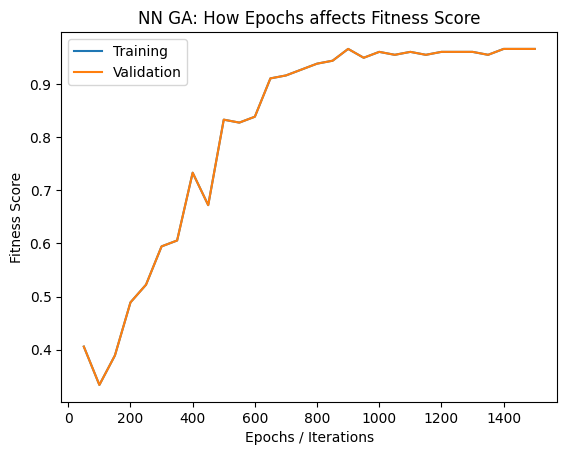

In [133]:
"""
Plotting the fitness score (Y axis) to number of epochs / iterations (X axis) for KnapSack
"""

plt.plot(iteration_sizes, train_fitness_scores, label = 'Training')
plt.plot(iteration_sizes, val_fitness_scores, label = 'Validation')

plt.xlabel("Epochs / Iterations")
plt.ylabel("Fitness Score")
plt.title("NN GA: How Epochs affects Fitness Score")
plt.legend()
plt.show()

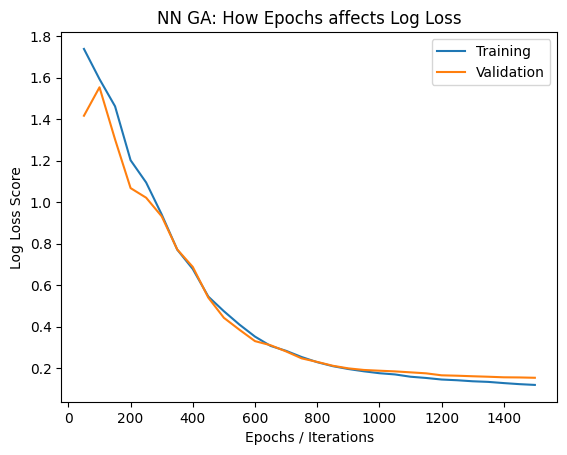

In [134]:
"""
Plotting the fitness score (Y axis) to number of epochs / iterations (X axis) for KnapSack
"""

plt.plot(iteration_sizes, train_loss_scores, label = 'Training')
plt.plot(iteration_sizes, val_loss_scores, label = 'Validation')

plt.xlabel("Epochs / Iterations")
plt.ylabel("Log Loss Score")
plt.title("NN GA: How Epochs affects Log Loss")
plt.legend()
plt.show()

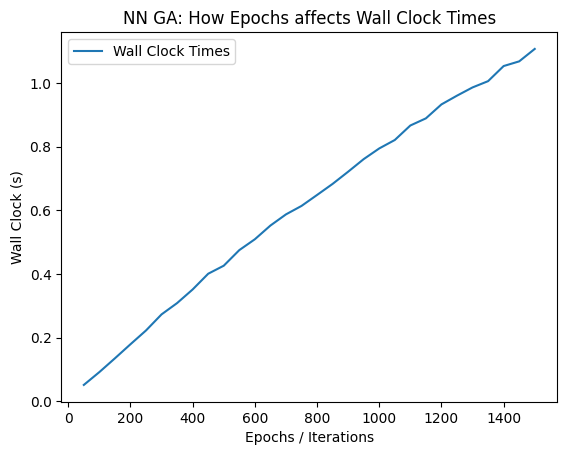

In [135]:
"""
Plotting the fitness score (Y axis) to number of epochs / iterations (X axis) for KnapSack
"""

plt.plot(iteration_sizes, wall_clock_time, label = 'Wall Clock Times')

plt.xlabel("Epochs / Iterations")
plt.ylabel("Wall Clock (s)")
plt.title("NN GA: How Epochs affects Wall Clock Times")
plt.legend()
plt.show()